In [169]:
import torch
import torchvision  #contains data loaders and transformers for common datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

Steps:
1. Download the data
2. Do transformations
3. Load the data


__A. Download the data :__ torchvision already has few popular and commonly used datasets like MNIST, CIFAR, COCO, ImageNet in its collection and CIFAR10 is one of them on which we will be doing image classification. So, we download the training and testing dataset using the above transformations.

__B. Do transformations :__  Here, we are using transforms to transform the data. Transforms are common image transformations in torchvision. We are using 3 transformations here  : Compose, ToTensor and Normalize.

__*transforms.Compose*__ : It chains/clubs all the transformations that we provide inside it.

__*transforms.ToTensor()*__ : Converts the image or numpy array of shape(HxWxC) in range [0, 255] to a torch float tensor of shape (CxHxW) in range [0.0, 1.0]. This operates on all 3 channels for each pixel and divides each value by 255 to bring it in the range of [0, 1]

__*transforms.Normalize*__ : We normalize the image by: image = (image - mean)/std) which brings the image in the range [-1,1]. To bring back the image to [0,1] range, we can do image = (image * std) + mean


__C. Load the data :__ For loading the data, we are using DataLoader which is a python iterator that will return elements from the dataset batch by batch. Here, we pass the dataset, batchsize and shuffle as few parameters.
We can also specify num_workers which helps to perform multi-process data loading. It's 0 by default that means it  uses single threading.


In [62]:
#Loading and transforming the data 

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [63]:
print(len(trainset), len(testset))
len(trainloader), len(testloader) #loader/4

50000 10000


(12500, 2500)

Now, let's see few random images

torch.Size([4, 3, 32, 32])
torch.Size([3, 36, 138])
(3, 36, 138)


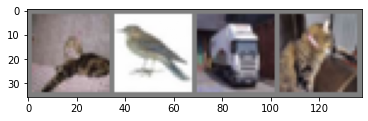

  cat  bird truck   cat


In [77]:
#Checking some random images
def imshow(img):
    print(img.shape)
    img = img / 2 + 0.5     # unnormalize to bring in range [0,1]
    npimg = img.numpy() #(3,M,N)
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Reshaping as imshow takes image in (M,N,3) format. 
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' %classes[labels[j]] for j in range(4)))


We will be defining a Convolution Neural Network first. We are using in_channels and out_channels as parameters.
For convolution layer, in_channels is 3 as we have RGB as 3 channels for the input image. But out_channel is something we decide on our own which goes as input to next layer.
It's very important to be aware of the shape of the image going in and out of the network layer.

We can find the output size by:

output_size = (N - F)/S + 1

where N : image size
F : filter/ kernel size
S : stride 

In [185]:
#Defining a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) 
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, input):
        output = self.conv1(input) 
        output = F.relu(output)
        output = self.pool(output)
        output = self.pool(F.relu(self.conv2(output)))
        output = output.view(-1, 16*5*5)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output
    
net = Net()
        

In [113]:
#Defining the loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now, that we have defined our network, loss and the optimizer that we would be using,
we will go ahead and train the data.

In pytorch, CrossEntropyLoss combines nn.LogSoftmax() and nn.NLLLoss() in one single class and is useful for
training a classification problem with C classes.

And we are using momentum algo for optimization, where momentum is the velocity which helps us to move
towards slope in case of saddle points where gradient becomes zero.

In [115]:
#Training the network

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.209
[1,  4000] loss: 1.193
[1,  6000] loss: 1.197
[1,  8000] loss: 1.184
[1, 10000] loss: 1.198
[1, 12000] loss: 1.190
[2,  2000] loss: 1.084
[2,  4000] loss: 1.086
[2,  6000] loss: 1.122
[2,  8000] loss: 1.132
[2, 10000] loss: 1.106
[2, 12000] loss: 1.105
[3,  2000] loss: 1.019
[3,  4000] loss: 1.039
[3,  6000] loss: 1.038
[3,  8000] loss: 1.057
[3, 10000] loss: 1.043
[3, 12000] loss: 1.047
[4,  2000] loss: 0.947
[4,  4000] loss: 0.971
[4,  6000] loss: 0.969
[4,  8000] loss: 1.011
[4, 10000] loss: 1.002
[4, 12000] loss: 1.012
[5,  2000] loss: 0.936
[5,  4000] loss: 0.929
[5,  6000] loss: 0.948
[5,  8000] loss: 0.943
[5, 10000] loss: 0.965
[5, 12000] loss: 0.943
Finished Training


In [117]:
#Saving the model

PATH = "./cifar_model.pth"
torch.save(net.state_dict(), PATH)

torch.Size([3, 36, 138])
(3, 36, 138)


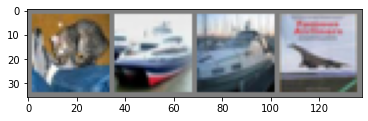

GroundTruth:  cat ship ship plane


In [132]:
#Checking the images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

We will load the saved model and call the net function with the images for which we want to predict the labels.
And then we use torch.max to find the highest prediction for each image. Torch.max returns 2 outputs:      
-prediction for each image      
-indices of class of each image

In [122]:
#Loading the data

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

#Testing the model on test data

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


Predicted:    dog  ship  ship plane


Our model predicted 3 images correctly out of 4 that we tested. Now let's find the accuracy of the model.
For checking the accuracy, we will only be concerned with the forward pass of the network. We don't need 
gradients that we used for backward propagation for optimizing the model.We will get the accuracy by diving the correct predictions by the total no. of test images.

In [168]:
#Checking accuracy on whole dataset

correct = 0
total = 0

with torch.no_grad():
    i = 0
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


And we got 61% accuracy for our model. Now let's check how each class performed

In [153]:
#Checking each class's performance

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 58 %
Accuracy of   car : 81 %
Accuracy of  bird : 51 %
Accuracy of   cat : 37 %
Accuracy of  deer : 56 %
Accuracy of   dog : 59 %
Accuracy of  frog : 57 %
Accuracy of horse : 67 %
Accuracy of  ship : 80 %
Accuracy of truck : 66 %
